In [38]:
import sys
import os
sys.path.insert(0,'../classes')
sys.path.insert(0,'../analysis')
sys.path.insert(0,'/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new')
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
sys.path.insert(0,hqfd)
from fourinarowfunctions import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
# participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_4' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/'

import load
import plot_fun
from importlib import reload
reload(load)

In [6]:
subdir

'/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/checkpoints_mcts100_cpuct2_id-3754964'

In [7]:
splits_subdir

['checkpoints_mcts100_cpuct2_id-3754964',
 'checkpoints_mcts100_cpuct2_id-3752918',
 'checkpoints_mcts100_cpuct2_id-3752919',
 'checkpoints_mcts100_cpuct2_id-3752921',
 'checkpoints_mcts100_cpuct2_id-3753063',
 'checkpoints_mcts100_cpuct2_id-3752985',
 'checkpoints_mcts100_cpuct2_id-3752917',
 'checkpoints_mcts100_cpuct2_id-3751934',
 'checkpoints_mcts100_cpuct2_id-37549660',
 'checkpoints_mcts100_cpuct2_id-3754965']

In [15]:
# splits_subdir = os.listdir(splits_dir)
splits_subdir = ['checkpoints_mcts100_cpuct2_id-3754964']
params_all_subj_dict_l = []
for subdir in splits_subdir:
    if subdir.startswith('checkpoints_'):
        subdir = os.path.join(splits_dir, subdir)
        params_all_subj_dict = load.read_all_subjects(subdir,None)
        params_all_subj_dict_l.append(params_all_subj_dict)

mcts100_cpuct2;10;cog cannot be loaded
mcts100_cpuct2;50;cog cannot be loaded


In [14]:
splits_subdir

['checkpoints_mcts100_cpuct2_id-3754964',
 'checkpoints_mcts100_cpuct2_id-3752918',
 'checkpoints_mcts100_cpuct2_id-3752919',
 'checkpoints_mcts100_cpuct2_id-3752921',
 'checkpoints_mcts100_cpuct2_id-3753063',
 'checkpoints_mcts100_cpuct2_id-3752985',
 'checkpoints_mcts100_cpuct2_id-3752917',
 'checkpoints_mcts100_cpuct2_id-3751934',
 'checkpoints_mcts100_cpuct2_id-37549660',
 'checkpoints_mcts100_cpuct2_id-3754965']

In [16]:
params_all_subj_dict

pruning_thresh    stop_p  feat_drop     lapse  \
mcts100_cpuct2;7  0         2.11370  0.001253   0.445160  0.050000   
                  1         1.83620  0.005321   0.453700  0.050249   
                  2         9.99590  0.013038   0.195850  0.050622   
                  3         6.25040  0.017738   0.485000  0.061660   
                  4         3.31140  0.031426   0.443940  0.062142   
...                             ...       ...        ...       ...   
mcts100_cpuct2;62 0         7.23430  0.001050   0.159460  0.053486   
                  1         6.17550  0.004759   0.088041  0.080750   
                  2         2.57220  0.017028   0.305800  0.100030   
                  3         1.79570  0.007595   0.267940  0.050000   
                  4         0.91862  0.046754   0.171670  0.065906   

                     active_passive   center  two_con  two_uncon   three  \
mcts100_cpuct2;7  0         0.93411  0.69164  0.05513   0.466760  3.7339   
                  1         0.99011  1.15360  0.13876  -0.988000  7.0177   
                  2         0.65901  0.81714  0.53024   0.246130  4.7825   
                  3         1.15990  1.25820  0.76782  -1.145200  5.6363   
                  4         0.94700  1.08000  0.60425  -0.621110  4.9829   
...                             ...      ...      ...        ...     ...   
mcts100_cpuct2;62 0         0.25004  1.09970 -0.72686   0.179890  6.4061   
                  1         0.70954  1.64100  0.37358   0.088618  5.9387   
                  2         0.49847  1.34300  0.95179   0.035563  4.8693   
                  3         0.70069  1.12500  0.33072   0.881080  3.4873   
                  4         0.41684  0.84526  0.66267   1.364500  5.0619   

                        four    lltest  mcts  cpuct  iter  
mcts100_cpuct2;7  0   8.2574  1.670657   100      2     7  
                  1   9.9147  2.848300   100      2     7  
                  2   9.8962  2.426286   100      2     7  
                  3   9.3492  3.191971   100      2     7  
                  4   6.8598  1.567914   100      2     7  
...                      ...       ...   ...    ...   ...  
mcts100_cpuct2;62 0   9.9945  1.865000   100      2    62  
                  1   6.4373  3.048086   100      2    62  
                  2   6.9370  1.820600   100      2    62  
                  3   9.4834  2.602771   100      2    62  
                  4  10.0000  1.028557   100      2    62  

[380 rows x 14 columns]

In [1]:
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
move_stats_hvh = np.loadtxt(os.path.join(hqfd,'move_stats_hvh.txt'),dtype=int)
feature_counts = np.loadtxt(os.path.join(hqfd,'optimal_feature_vals.txt'))[:,-35:]
optimal_move_values = np.loadtxt(os.path.join(hqfd,'opt_hvh.txt'))[:,-36:]

NameError: name 'np' is not defined

In [29]:
optimal_move_values

array([[-2.22045e-16, -2.22045e-16,  0.00000e+00, ..., -2.22045e-16,
        -2.22045e-16, -2.22045e-16],
       [ 1.20000e+00,  0.00000e+00,  0.00000e+00, ...,  1.20000e+00,
         1.20000e+00,  1.20000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 0.00000e+00,          nan,          nan, ...,          nan,
                 nan,  0.00000e+00],
       [ 1.00000e+04,          nan,          nan, ...,          nan,
                 nan,  1.00000e+04],
       [-1.00000e+04,          nan,          nan, ...,          nan,
                 nan, -1.00000e+04]])

In [39]:
df = params_all_subj_dict
params = np.array([expand_params(r) for r in df.values[:,:10].astype(float)])

# df['feature drop rate'] = params[:,-1]
df['heuristic quality'] = np.apply_along_axis(get_heuristic_quality,1,params)

In [40]:
df

pruning_thresh    stop_p  feat_drop     lapse  \
mcts100_cpuct2;7  0         2.11370  0.001253   0.445160  0.050000   
                  1         1.83620  0.005321   0.453700  0.050249   
                  2         9.99590  0.013038   0.195850  0.050622   
                  3         6.25040  0.017738   0.485000  0.061660   
                  4         3.31140  0.031426   0.443940  0.062142   
...                             ...       ...        ...       ...   
mcts100_cpuct2;62 0         7.23430  0.001050   0.159460  0.053486   
                  1         6.17550  0.004759   0.088041  0.080750   
                  2         2.57220  0.017028   0.305800  0.100030   
                  3         1.79570  0.007595   0.267940  0.050000   
                  4         0.91862  0.046754   0.171670  0.065906   

                     active_passive   center  two_con  two_uncon   three  \
mcts100_cpuct2;7  0         0.93411  0.69164  0.05513   0.466760  3.7339   
                  1         0.99011  1.15360  0.13876  -0.988000  7.0177   
                  2         0.65901  0.81714  0.53024   0.246130  4.7825   
                  3         1.15990  1.25820  0.76782  -1.145200  5.6363   
                  4         0.94700  1.08000  0.60425  -0.621110  4.9829   
...                             ...      ...      ...        ...     ...   
mcts100_cpuct2;62 0         0.25004  1.09970 -0.72686   0.179890  6.4061   
                  1         0.70954  1.64100  0.37358   0.088618  5.9387   
                  2         0.49847  1.34300  0.95179   0.035563  4.8693   
                  3         0.70069  1.12500  0.33072   0.881080  3.4873   
                  4         0.41684  0.84526  0.66267   1.364500  5.0619   

                        four    lltest  mcts  cpuct  iter  heuristic quality  
mcts100_cpuct2;7  0   8.2574  1.670657   100      2     7           0.515437  
                  1   9.9147  2.848300   100      2     7           0.454790  
                  2   9.8962  2.426286   100      2     7           0.578064  
                  3   9.3492  3.191971   100      2     7           0.432719  
                  4   6.8598  1.567914   100      2     7           0.475195  
...                      ...       ...   ...    ...   ...                ...  
mcts100_cpuct2;62 0   9.9945  1.865000   100      2    62           0.403371  
                  1   6.4373  3.048086   100      2    62           0.484457  
                  2   6.9370  1.820600   100      2    62           0.500421  
                  3   9.4834  2.602771   100      2    62           0.496044  
                  4  10.0000  1.028557   100      2    62           0.621558  

[380 rows x 15 columns]

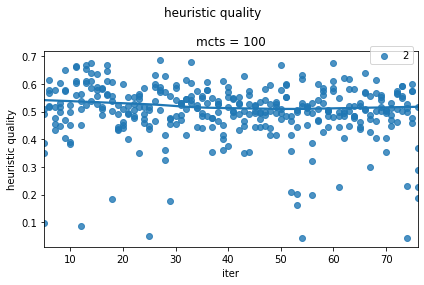

In [43]:
plot_fun.plot_one_feat_vs_iter(df,'heuristic quality')